# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

2023-10-20 23:50:02.003777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 23:50:02.064137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 23:50:02.064940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 23:50:03.495033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

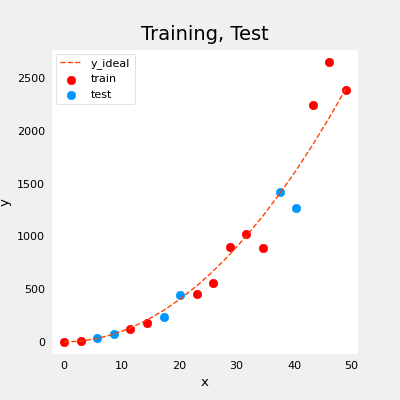

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m) 
    ### END CODE HERE ### 
    
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

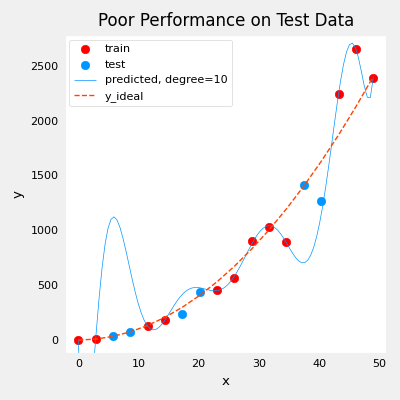

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

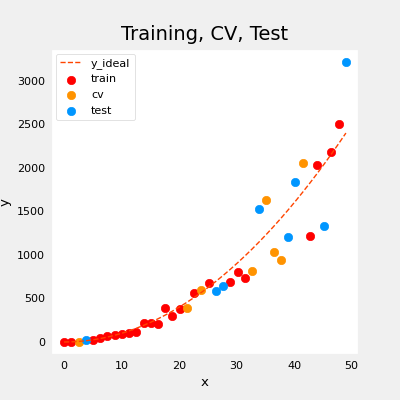

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

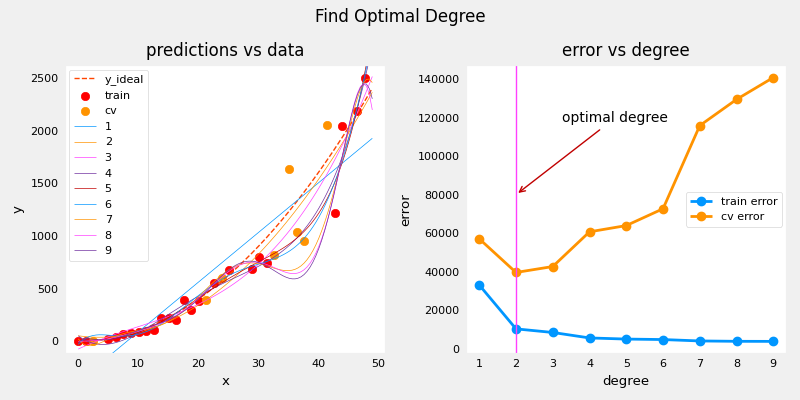

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

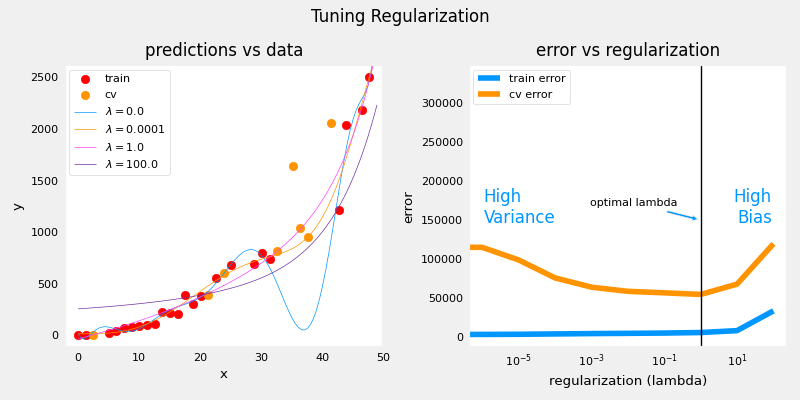

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

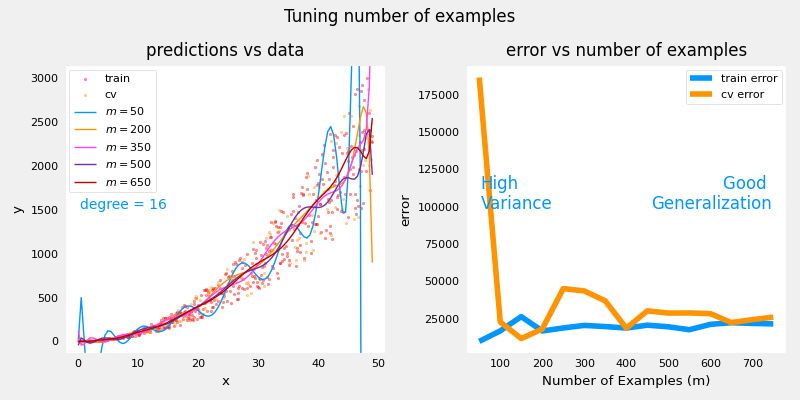

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


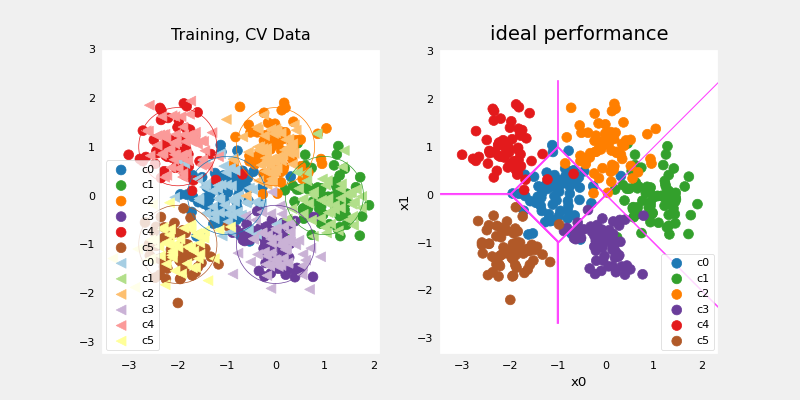

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    ### END CODE HERE ### 
    
    return(cerr)

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [22]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ###
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")
  
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 1.0588
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4208
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3232
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2823
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2780
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2921
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2509
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2270
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2352
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2034
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2207
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2089
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.1755
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1682
Epoch 103/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1837
Epoch 104/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1576
Epoch 105/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1513
Epoch 106/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1415
Epoch 107/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.1556
Epoch 108/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1442
Epoch 109/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1480
Epoch 110/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1419
Epoch 111/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1534
Epoch 112/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1633
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1163
Epoch 200/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1168
Epoch 201/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1021
Epoch 203/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1020
Epoch 204/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1248
Epoch 205/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1145
Epoch 206/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1372
Epoch 207/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1427
Epoch 208/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1463
Epoch 209/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1575
Epoch 210/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1390
Epoch 211/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0690
Epoch 298/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0696
Epoch 299/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0704
Epoch 300/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0697
Epoch 301/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0762
Epoch 302/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0888
Epoch 303/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0944
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0758
Epoch 305/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0844
Epoch 306/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0848
Epoch 307/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0852
Epoch 308/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0738
Epoch 309/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.0631
Epoch 396/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0612
Epoch 397/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0638
Epoch 398/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0677
Epoch 399/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0552
Epoch 400/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1260
Epoch 402/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1106
Epoch 403/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0787
Epoch 404/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1499
Epoch 405/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1249
Epoch 406/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1006
Epoch 407/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 494/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0394
Epoch 495/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0378
Epoch 496/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0375
Epoch 497/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0346
Epoch 498/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0436
Epoch 499/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0376
Epoch 500/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0359
Epoch 501/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0439
Epoch 502/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0466
Epoch 503/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0500
Epoch 504/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0652
Epoch 505/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 592/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 593/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0384
Epoch 594/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0384
Epoch 595/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0658
Epoch 596/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0724
Epoch 597/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 598/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0685
Epoch 599/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0586
Epoch 600/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0371
Epoch 601/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0410
Epoch 602/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0341
Epoch 603/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0323
Epoch 690/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 691/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 692/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 693/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 694/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 695/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 697/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 698/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0320
Epoch 699/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0417
Epoch 700/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0262
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 789/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 790/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 791/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0368
Epoch 792/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0326
Epoch 793/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0321
Epoch 794/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0334
Epoch 795/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0442
Epoch 796/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 797/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0407
Epoch 798/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 799/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0610
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0591
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0463
Epoch 888/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 889/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 890/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0403
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0276
Epoch 892/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 893/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 896/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 986/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 987/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 988/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 989/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0933
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0883
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1384
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 995/1000
13/1

In [23]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0266
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0394
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 104/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0428
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1236
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2262
Epoch 110/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2942
Epoch 111/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1831
Epoch 112/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1714
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 202/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 203/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 205/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 211/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.0694
Epoch 298/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 299/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1402
Epoch 300/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1793
Epoch 301/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1937
Epoch 302/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2723
Epoch 303/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2115
Epoch 304/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1232
Epoch 305/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1103
Epoch 306/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 307/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 308/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 402/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2154
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1590
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1393
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 497/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 498/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 499/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 500/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 502/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 505/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 592/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0105
Epoch 593/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 594/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 595/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 598/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 599/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 602/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 603/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 692/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 693/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 694/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 699/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 788/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0242
Epoch 789/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 790/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 796/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 797/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 798/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 799/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 896/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 897/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0213
Epoch 984/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 985/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0309
Epoch 986/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 987/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 988/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 989/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 990/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 991/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0488
Epoch 992/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 993/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0353
Epoch 994/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0217
Epoch 995/1000
13/1

In [24]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 3s 3ms/step


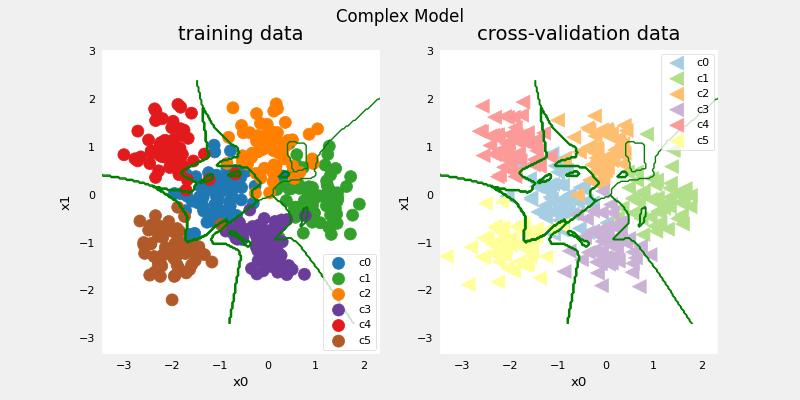

In [25]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [26]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 2ms/step
categorization error, training, complex model: 0.003
categorization error, cv,       complex model: 0.125


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [27]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ###
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
      
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
    ### START CODE HERE ### 
)


In [28]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 1.2806
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0105
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8233
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6766
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5589
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4667
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4098
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3692
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3410
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3186
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3027
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2921
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1996
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2004
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1968
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1957
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1957
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1945
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1953
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1970
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1972
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1948
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1970
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1916
Epoch 200/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1888
Epoch 201/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1892
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1867
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1889
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1894
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1879
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1917
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1872
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1926
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1878
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1894
Epoch 211/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.1897
Epoch 298/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1882
Epoch 299/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1838
Epoch 300/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1891
Epoch 301/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1852
Epoch 302/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1899
Epoch 303/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1826
Epoch 304/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1906
Epoch 305/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1837
Epoch 306/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1848
Epoch 307/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1845
Epoch 308/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1845
Epoch 309/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.1807
Epoch 396/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1840
Epoch 397/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1853
Epoch 398/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1831
Epoch 399/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1807
Epoch 400/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1831
Epoch 401/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1822
Epoch 402/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1808
Epoch 403/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1809
Epoch 404/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1820
Epoch 405/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1790
Epoch 406/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.1801
Epoch 407/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.1830
Epoch 494/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1801
Epoch 495/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1792
Epoch 496/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1826
Epoch 497/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1779
Epoch 498/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1789
Epoch 499/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1784
Epoch 500/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1783
Epoch 501/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1834
Epoch 502/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1806
Epoch 503/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1811
Epoch 504/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1784
Epoch 505/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.1822
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1782
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1796
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1782
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1822
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1767
Epoch 597/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1801
Epoch 598/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1779
Epoch 599/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1769
Epoch 600/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1795
Epoch 601/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1772
Epoch 602/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1799
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1767
Epoch 692/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1783
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1782
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1765
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1765
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1769
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1787
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1765
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1760
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1795
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1789
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1750
Epoch 789/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1768
Epoch 790/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1799
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1755
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1756
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1803
Epoch 794/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1799
Epoch 795/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1767
Epoch 796/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1781
Epoch 797/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1775
Epoch 798/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1781
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1767
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1752
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1781
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1757
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1755
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1759
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1778
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1765
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1768
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1778
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1759
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1739
Epoch 986/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1770
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1747
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1775
Epoch 989/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1779
Epoch 990/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1752
Epoch 991/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1747
Epoch 992/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1762
Epoch 993/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1757
Epoch 994/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1757
Epoch 995/1000
13/1

In [29]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 4s 4ms/step


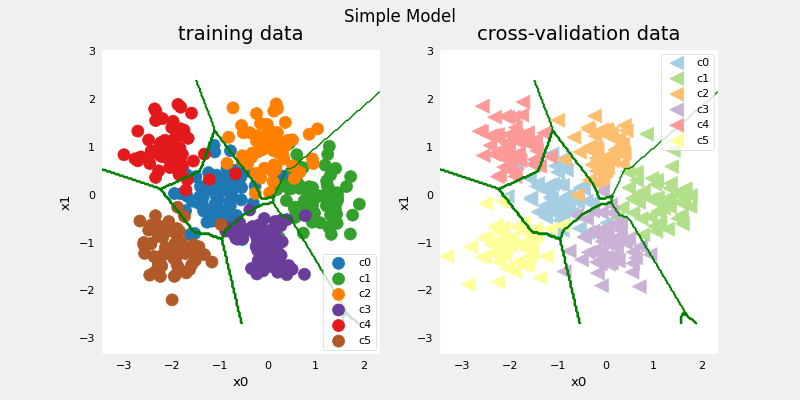

In [30]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [31]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 3ms/step
categorization error, training, simple model, 0.068, complex model: 0.003
categorization error, cv,       simple model, 0.059, complex model: 0.125


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [33]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ###
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")
        
        ### START CODE HERE ### 
    ], name= "ComplexRegularized"
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [34]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 4.4644
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.6972
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.3398
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0823
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0045
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9675
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9551
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.8838
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.8182
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7771
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7525
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.4856
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4689
Epoch 103/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4696
Epoch 104/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4581
Epoch 105/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.5051
Epoch 106/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4684
Epoch 107/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4598
Epoch 108/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4688
Epoch 109/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4554
Epoch 110/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.4526
Epoch 111/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.4541
Epoch 112/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4474
Epoch 113/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.4076
Epoch 200/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4026
Epoch 201/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4268
Epoch 202/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3943
Epoch 203/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3978
Epoch 204/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4088
Epoch 205/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4605
Epoch 206/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4329
Epoch 207/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4100
Epoch 208/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4167
Epoch 209/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4387
Epoch 210/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4133
Epoch 211/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3851
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3885
Epoch 299/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3911
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4231
Epoch 301/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3897
Epoch 302/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3898
Epoch 303/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3866
Epoch 304/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3794
Epoch 305/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3788
Epoch 306/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3880
Epoch 307/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3923
Epoch 308/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3876
Epoch 309/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.3912
Epoch 396/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3793
Epoch 397/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3911
Epoch 398/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.3765
Epoch 399/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3737
Epoch 400/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3713
Epoch 401/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.3566
Epoch 402/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3594
Epoch 403/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3586
Epoch 404/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3597
Epoch 405/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3529
Epoch 406/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3589
Epoch 407/1000
13/

13/13 [==============================] - 0s 6ms/step - loss: 0.3495
Epoch 494/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3519
Epoch 495/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3501
Epoch 496/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3721
Epoch 497/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4005
Epoch 498/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3485
Epoch 499/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3418
Epoch 500/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3587
Epoch 501/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3524
Epoch 502/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3579
Epoch 503/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3789
Epoch 504/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3684
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3450
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3424
Epoch 593/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3397
Epoch 594/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3383
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4185
Epoch 596/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3962
Epoch 597/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3550
Epoch 598/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3432
Epoch 599/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3383
Epoch 600/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3552
Epoch 601/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3349
Epoch 602/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3429
Epoch 603/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3986
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3697
Epoch 691/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3461
Epoch 692/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3498
Epoch 693/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3459
Epoch 694/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3426
Epoch 695/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3348
Epoch 696/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3315
Epoch 697/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3301
Epoch 698/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3443
Epoch 699/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3390
Epoch 700/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3461
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3344
Epoch 788/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3293
Epoch 789/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3361
Epoch 790/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3354
Epoch 791/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3673
Epoch 792/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3712
Epoch 793/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3454
Epoch 794/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3499
Epoch 795/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3494
Epoch 796/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3714
Epoch 797/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3230
Epoch 798/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3590
Epoch 799/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3457
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3462
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3276
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3383
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3397
Epoch 890/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3744
Epoch 891/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3278
Epoch 892/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 893/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3334
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3435
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3879
Epoch 896/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3572
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3131
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3271
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3388
Epoch 986/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3376
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3430
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3528
Epoch 989/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3498
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3403
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3395
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3445
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3215
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3198
Epoch 995/1000
13/1

In [35]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "ComplexRegularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 2s 2ms/step


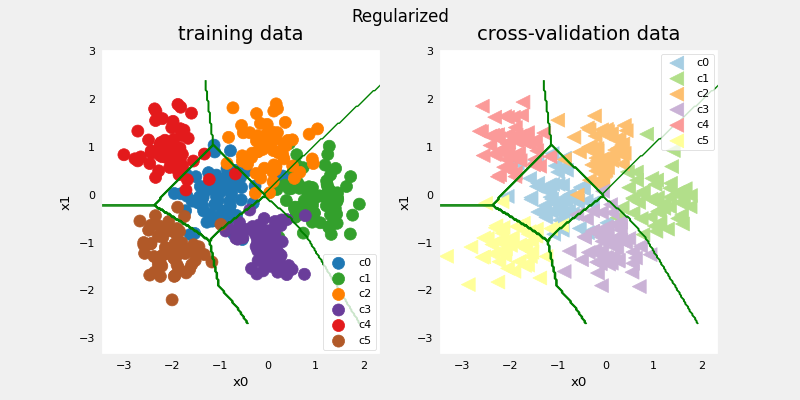

In [36]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [37]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 3ms/step
categorization error, training, regularized: 0.072, simple model, 0.068, complex model: 0.003
categorization error, cv,       regularized: 0.072, simple model, 0.059, complex model: 0.125


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [38]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 1s 5ms/step - loss: 1.0447
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3950
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3042
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2655
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2700
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2953
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2500
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2339
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2414
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2024
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2201
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2052
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1717
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1651
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1906
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1705
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1575
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1496
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1642
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1477
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1514
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1491
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1504
Epoch 112/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1622
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1100
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1178
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1122
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1059
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1050
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1197
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1078
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1128
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1643
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1861
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1277
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1110
Epoch 211/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0859
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0916
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1034
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0834
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0842
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0822
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0900
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0716
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0796
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0961
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0746
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0786
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0559
Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0815
Epoch 402/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0414
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0438
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0420
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0549
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0920
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 594/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0464
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0527
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0760
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0944
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0455
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0346
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0379
Epoch 691/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0610
Epoch 692/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1300
Epoch 693/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0966
Epoch 694/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0904
Epoch 695/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0939
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2088
Epoch 789/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 790/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1666
Epoch 791/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1327
Epoch 792/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2129
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1254
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1220
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2464
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 797/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0652
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 889/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 890/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 897/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0347
Epoch 984/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0282
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 986/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0294
Epoch 989/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0429
Epoch 990/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 995/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.2449
Epoch 83/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2343
Epoch 84/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2363
Epoch 85/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2480
Epoch 86/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2243
Epoch 87/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2271
Epoch 88/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2352
Epoch 89/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2313
Epoch 90/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2268
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2183
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2183
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2213
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2222
Epoch 182/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2095
Epoch 183/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2076
Epoch 184/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2134
Epoch 185/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2097
Epoch 186/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2048
Epoch 187/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2015
Epoch 188/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2019
Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2003
Epoch 190/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2087
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2140
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2032
Epoch 193/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1999
Epoch 280/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1982
Epoch 281/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1965
Epoch 282/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1906
Epoch 283/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2014
Epoch 284/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1894
Epoch 285/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1864
Epoch 286/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1925
Epoch 287/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1962
Epoch 288/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2149
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2056
Epoch 290/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2023
Epoch 291/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1783
Epoch 378/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1817
Epoch 379/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1877
Epoch 380/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1843
Epoch 381/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1817
Epoch 382/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1919
Epoch 383/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2022
Epoch 384/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1880
Epoch 385/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 386/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1804
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1830
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1825
Epoch 389/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1904
Epoch 476/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 477/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1899
Epoch 478/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1948
Epoch 479/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1825
Epoch 480/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1861
Epoch 481/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1755
Epoch 482/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 483/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1823
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1855
Epoch 485/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1746
Epoch 486/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1718
Epoch 487/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1685
Epoch 574/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1663
Epoch 575/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1597
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1614
Epoch 577/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1679
Epoch 578/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1652
Epoch 579/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1642
Epoch 580/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1716
Epoch 581/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1674
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1577
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1635
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1703
Epoch 585/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1614
Epoch 672/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1645
Epoch 673/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1585
Epoch 674/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1676
Epoch 675/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1641
Epoch 676/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1600
Epoch 677/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1555
Epoch 678/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1610
Epoch 679/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1745
Epoch 680/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1739
Epoch 681/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1712
Epoch 682/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1748
Epoch 683/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1523
Epoch 770/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1586
Epoch 771/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1552
Epoch 772/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1506
Epoch 773/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1565
Epoch 774/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1665
Epoch 775/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1640
Epoch 776/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1498
Epoch 777/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1594
Epoch 778/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1578
Epoch 779/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1558
Epoch 780/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1543
Epoch 781/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1447
Epoch 868/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1530
Epoch 869/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1511
Epoch 870/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1552
Epoch 871/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1541
Epoch 872/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1459
Epoch 873/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1486
Epoch 874/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1450
Epoch 875/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1480
Epoch 876/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1459
Epoch 877/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1479
Epoch 878/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1522
Epoch 879/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1404
Epoch 966/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1456
Epoch 967/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1547
Epoch 968/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1560
Epoch 969/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1528
Epoch 970/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1517
Epoch 971/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1452
Epoch 972/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1408
Epoch 973/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1422
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1461
Epoch 975/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1431
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1394
Epoch 977/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3484
Epoch 65/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3578
Epoch 66/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3325
Epoch 67/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3533
Epoch 68/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3443
Epoch 69/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3207
Epoch 70/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3159
Epoch 71/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3272
Epoch 72/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2950
Epoch 73/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3055
Epoch 74/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3112
Epoch 75/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3223
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2832
Epoch 164/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 165/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2855
Epoch 166/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2888
Epoch 167/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2842
Epoch 168/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2879
Epoch 169/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2797
Epoch 170/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2795
Epoch 171/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2725
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2638
Epoch 173/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2834
Epoch 174/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2907
Epoch 175/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2710
Epoch 262/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2685
Epoch 263/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2621
Epoch 264/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2549
Epoch 265/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2683
Epoch 266/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2809
Epoch 267/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2745
Epoch 268/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2656
Epoch 269/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2559
Epoch 270/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2712
Epoch 271/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2546
Epoch 272/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2611
Epoch 273/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2534
Epoch 360/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2818
Epoch 361/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2519
Epoch 362/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2762
Epoch 363/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2785
Epoch 364/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2622
Epoch 365/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2560
Epoch 366/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2584
Epoch 367/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2785
Epoch 368/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2688
Epoch 369/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2580
Epoch 370/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2567
Epoch 371/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2389
Epoch 458/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2591
Epoch 459/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2467
Epoch 460/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2408
Epoch 461/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2663
Epoch 462/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2382
Epoch 463/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2397
Epoch 464/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2509
Epoch 465/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2551
Epoch 466/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2491
Epoch 467/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2495
Epoch 468/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2538
Epoch 469/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2456
Epoch 556/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2346
Epoch 557/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2404
Epoch 558/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2467
Epoch 559/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2678
Epoch 560/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2532
Epoch 561/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2489
Epoch 562/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2594
Epoch 563/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 564/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2458
Epoch 565/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2424
Epoch 566/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2428
Epoch 567/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2309
Epoch 654/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2381
Epoch 655/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2318
Epoch 656/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2325
Epoch 657/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2340
Epoch 658/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2424
Epoch 659/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2355
Epoch 660/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2354
Epoch 661/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2288
Epoch 662/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2449
Epoch 663/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2405
Epoch 664/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2605
Epoch 665/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2357
Epoch 752/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2535
Epoch 753/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2241
Epoch 754/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2375
Epoch 755/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2291
Epoch 756/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2473
Epoch 757/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2468
Epoch 758/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 759/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2305
Epoch 760/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2433
Epoch 761/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2561
Epoch 762/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2382
Epoch 763/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2232
Epoch 850/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2298
Epoch 851/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2333
Epoch 852/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2485
Epoch 853/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2377
Epoch 854/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2361
Epoch 855/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2406
Epoch 856/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2233
Epoch 857/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2319
Epoch 858/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2362
Epoch 859/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2582
Epoch 860/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2415
Epoch 861/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2411
Epoch 948/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2488
Epoch 949/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 950/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2214
Epoch 951/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2295
Epoch 952/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2578
Epoch 953/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2481
Epoch 954/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2452
Epoch 955/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2322
Epoch 956/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2378
Epoch 957/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2354
Epoch 958/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2451
Epoch 959/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4573
Epoch 47/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4357
Epoch 48/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4835
Epoch 49/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4743
Epoch 50/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4452
Epoch 51/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4523
Epoch 52/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4369
Epoch 53/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4516
Epoch 54/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4334
Epoch 55/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4632
Epoch 56/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4312
Epoch 57/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4449
Epoch 58/1000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.3618
Epoch 146/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3592
Epoch 147/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3785
Epoch 148/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3628
Epoch 149/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3568
Epoch 150/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3584
Epoch 151/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3572
Epoch 152/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3539
Epoch 153/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3784
Epoch 154/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3586
Epoch 155/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3576
Epoch 156/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3647
Epoch 157/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 244/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3461
Epoch 245/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3429
Epoch 246/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3356
Epoch 247/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3279
Epoch 248/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3407
Epoch 249/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3515
Epoch 250/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3437
Epoch 251/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3628
Epoch 252/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3405
Epoch 253/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3405
Epoch 254/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3596
Epoch 255/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 342/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3377
Epoch 343/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3238
Epoch 344/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3199
Epoch 345/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3188
Epoch 346/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3287
Epoch 347/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3316
Epoch 348/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 349/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3085
Epoch 350/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3297
Epoch 351/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3151
Epoch 352/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3354
Epoch 353/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3097
Epoch 440/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3033
Epoch 441/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3111
Epoch 442/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3194
Epoch 443/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3148
Epoch 444/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3069
Epoch 445/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3179
Epoch 446/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3129
Epoch 447/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3383
Epoch 448/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3282
Epoch 449/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3075
Epoch 450/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3065
Epoch 451/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3550
Epoch 538/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3187
Epoch 539/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2937
Epoch 540/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3118
Epoch 541/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3268
Epoch 542/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3342
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3260
Epoch 544/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3149
Epoch 545/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3036
Epoch 546/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3151
Epoch 547/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3335
Epoch 548/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3074
Epoch 549/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.3317
Epoch 636/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3140
Epoch 637/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3032
Epoch 638/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2973
Epoch 639/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2942
Epoch 640/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2894
Epoch 641/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2900
Epoch 642/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3087
Epoch 643/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3230
Epoch 644/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2938
Epoch 645/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3092
Epoch 646/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3176
Epoch 647/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2995
Epoch 734/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3073
Epoch 735/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2980
Epoch 736/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3087
Epoch 737/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3202
Epoch 738/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3012
Epoch 739/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3053
Epoch 740/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3042
Epoch 741/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3154
Epoch 742/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3484
Epoch 743/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2981
Epoch 744/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2898
Epoch 745/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 832/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3147
Epoch 833/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3147
Epoch 834/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2936
Epoch 835/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2946
Epoch 836/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2859
Epoch 837/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3013
Epoch 838/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3105
Epoch 839/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2944
Epoch 840/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3047
Epoch 841/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2851
Epoch 842/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3107
Epoch 843/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3087
Epoch 930/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3128
Epoch 931/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3018
Epoch 932/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2987
Epoch 933/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2988
Epoch 934/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3267
Epoch 935/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 936/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2919
Epoch 937/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2915
Epoch 938/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3048
Epoch 939/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2870
Epoch 940/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2901
Epoch 941/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.6124
Epoch 29/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6007
Epoch 30/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6240
Epoch 31/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6162
Epoch 32/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6355
Epoch 33/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6186
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6676
Epoch 35/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6447
Epoch 36/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6092
Epoch 37/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5851
Epoch 38/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5680
Epoch 39/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.5639
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.4450
Epoch 128/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4337
Epoch 129/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4364
Epoch 130/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4358
Epoch 131/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4690
Epoch 132/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4390
Epoch 133/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4228
Epoch 134/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4478
Epoch 135/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4376
Epoch 136/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4480
Epoch 137/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4316
Epoch 138/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4528
Epoch 139/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4312
Epoch 226/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4296
Epoch 227/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4548
Epoch 228/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3975
Epoch 229/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3999
Epoch 230/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4139
Epoch 231/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4061
Epoch 232/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4123
Epoch 233/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3900
Epoch 234/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3907
Epoch 235/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3864
Epoch 236/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3932
Epoch 237/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4305
Epoch 324/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4213
Epoch 325/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3987
Epoch 326/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3890
Epoch 327/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3780
Epoch 328/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3977
Epoch 329/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3754
Epoch 330/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3639
Epoch 331/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3675
Epoch 332/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 333/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4136
Epoch 334/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3974
Epoch 335/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3723
Epoch 422/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3862
Epoch 423/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3655
Epoch 424/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3680
Epoch 425/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3528
Epoch 426/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3531
Epoch 427/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3571
Epoch 428/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3691
Epoch 429/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3663
Epoch 430/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3642
Epoch 431/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3506
Epoch 432/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3581
Epoch 433/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3611
Epoch 520/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3627
Epoch 521/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3420
Epoch 522/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3570
Epoch 523/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 524/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 525/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3457
Epoch 526/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 527/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3352
Epoch 528/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3428
Epoch 529/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3756
Epoch 530/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3627
Epoch 531/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3219
Epoch 618/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3674
Epoch 619/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3970
Epoch 620/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3847
Epoch 621/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3467
Epoch 622/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3472
Epoch 623/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3389
Epoch 624/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3268
Epoch 625/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3241
Epoch 626/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3380
Epoch 627/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3500
Epoch 628/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3653
Epoch 629/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3285
Epoch 716/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3349
Epoch 717/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3518
Epoch 718/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3681
Epoch 719/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4173
Epoch 720/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3943
Epoch 721/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3658
Epoch 722/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3372
Epoch 723/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3595
Epoch 724/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3379
Epoch 725/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3567
Epoch 726/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 727/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3260
Epoch 814/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3339
Epoch 815/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 816/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3363
Epoch 817/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3544
Epoch 818/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 819/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3351
Epoch 820/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3704
Epoch 821/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3721
Epoch 822/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 823/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3418
Epoch 824/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3492
Epoch 825/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3227
Epoch 912/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 913/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3195
Epoch 914/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3466
Epoch 915/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3408
Epoch 916/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3490
Epoch 917/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3379
Epoch 918/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3364
Epoch 919/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3455
Epoch 920/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4099
Epoch 921/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3813
Epoch 922/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3690
Epoch 923/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 1.0518
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0291
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9884
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9649
Epoch 13/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9561
Epoch 14/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9588
Epoch 15/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9177
Epoch 16/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9017
Epoch 17/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9209
Epoch 18/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9162
Epoch 19/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8807
Epoch 20/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8665
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5741
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5727
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5684
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5639
Epoch 113/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5573
Epoch 114/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5569
Epoch 115/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5578
Epoch 116/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5602
Epoch 117/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5938
Epoch 118/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5878
Epoch 119/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5810
Epoch 120/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5691
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.5148
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5202
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5335
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5053
Epoch 211/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5042
Epoch 212/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4926
Epoch 213/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4897
Epoch 214/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4839
Epoch 215/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4899
Epoch 216/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5095
Epoch 217/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4971
Epoch 218/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4927
Epoch 219/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4524
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4746
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4597
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4476
Epoch 309/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4593
Epoch 310/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4521
Epoch 311/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4441
Epoch 312/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4452
Epoch 313/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4509
Epoch 314/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4530
Epoch 315/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4483
Epoch 316/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4432
Epoch 317/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4367
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4391
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4231
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4286
Epoch 407/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4407
Epoch 408/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4476
Epoch 409/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4237
Epoch 410/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4432
Epoch 411/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4681
Epoch 412/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4266
Epoch 413/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4348
Epoch 414/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4440
Epoch 415/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4071
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4181
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4444
Epoch 504/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4509
Epoch 505/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4432
Epoch 506/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4557
Epoch 507/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4432
Epoch 508/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4041
Epoch 509/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4166
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4120
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4225
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4218
Epoch 513/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3949
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4073
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3924
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4061
Epoch 603/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4219
Epoch 604/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4124
Epoch 605/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4036
Epoch 606/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4259
Epoch 607/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4195
Epoch 608/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4208
Epoch 609/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4077
Epoch 610/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4296
Epoch 611/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3868
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4003
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3888
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3821
Epoch 701/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4063
Epoch 702/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4454
Epoch 703/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4065
Epoch 704/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4108
Epoch 705/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4615
Epoch 706/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4263
Epoch 707/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4146
Epoch 708/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3985
Epoch 709/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4378
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4468
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3812
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3913
Epoch 799/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Epoch 800/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3895
Epoch 801/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3782
Epoch 802/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3714
Epoch 803/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3693
Epoch 804/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3665
Epoch 805/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3847
Epoch 806/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3863
Epoch 807/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3895
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3792
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4201
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3915
Epoch 897/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3892
Epoch 898/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3879
Epoch 899/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4167
Epoch 900/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4033
Epoch 901/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4316
Epoch 902/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4251
Epoch 903/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4188
Epoch 904/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3739
Epoch 905/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3836
Epoch 992/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3641
Epoch 993/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3738
Epoch 994/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3803
Epoch 995/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3854
Epoch 996/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3794
Epoch 997/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4129
Epoch 998/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3732
Epoch 999/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3857
Epoch 1000/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3849
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 1s 4ms/step - loss: 10.0651
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 2.3221

13/13 [==============================] - 0s 3ms/step - loss: 0.6798
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6885
Epoch 92/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6695
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6620
Epoch 94/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6586
Epoch 95/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6685
Epoch 96/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6524
Epoch 97/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6574
Epoch 98/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6668
Epoch 99/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6963
Epoch 100/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7082
Epoch 101/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7021
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5697
Epoch 190/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5572
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5688
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5687
Epoch 193/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5621
Epoch 194/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5519
Epoch 195/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5526
Epoch 196/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5451
Epoch 197/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5580
Epoch 198/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5465
Epoch 199/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5548
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5580
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5665
Epoch 288/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5696
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5187
Epoch 290/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5156
Epoch 291/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5208
Epoch 292/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5034
Epoch 293/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5107
Epoch 294/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5147
Epoch 295/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5481
Epoch 296/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5163
Epoch 297/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5049
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5099
Epoch 299/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4870
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4726
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4919
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4902
Epoch 389/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4778
Epoch 390/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4694
Epoch 391/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4727
Epoch 392/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4791
Epoch 393/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4760
Epoch 394/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4781
Epoch 395/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4960
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5279
Epoch 397/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.5095
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4631
Epoch 485/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4927
Epoch 486/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4654
Epoch 487/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4603
Epoch 488/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4502
Epoch 489/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4453
Epoch 490/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4562
Epoch 491/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4619
Epoch 492/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4833
Epoch 493/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4611
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4457
Epoch 495/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4701
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4650
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4561
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4355
Epoch 585/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4501
Epoch 586/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4773
Epoch 587/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4483
Epoch 588/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4379
Epoch 589/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4204
Epoch 590/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4231
Epoch 591/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4328
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4310
Epoch 593/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4467
Epoch 680/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4288
Epoch 681/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4551
Epoch 682/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4279
Epoch 683/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4320
Epoch 684/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4376
Epoch 685/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4266
Epoch 686/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4283
Epoch 687/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4284
Epoch 688/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4465
Epoch 689/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5032
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4641
Epoch 691/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4499
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4463
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4271
Epoch 780/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4140
Epoch 781/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4488
Epoch 782/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4093
Epoch 783/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4212
Epoch 784/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4191
Epoch 785/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4069
Epoch 786/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4115
Epoch 787/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4191
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4097
Epoch 789/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4055
Epoch 876/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4159
Epoch 877/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4018
Epoch 878/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4136
Epoch 879/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4119
Epoch 880/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4203
Epoch 881/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4394
Epoch 882/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4552
Epoch 883/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4625
Epoch 884/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4476
Epoch 885/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4301
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 887/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3970
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3988
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3892
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3979
Epoch 977/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4022
Epoch 978/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3948
Epoch 979/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4145
Epoch 980/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4517
Epoch 981/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4340
Epoch 982/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4323
Epoch 983/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3980
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4056
Epoch 985/1000
13/1

In [ ]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

In [ ]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)